# My_BKP_Part-3-1 

## Исследуем возможности перцептрона по прогнозированию значения прочности при растяжении. 

# Исследование проводилось в Colab, так как KerasClassifier и MLPRegressor не заработали в MS Visual Studio Code

In [1]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras import utils

%matplotlib inline

In [2]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV,  RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.neural_network import MLPRegressor
#from tensorflow import Sequential

#from tensorflow.keras import Sequential
#from tensorflow.keras import layers
#from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Activation,  LSTM

#from sklearn.ensemble import RandomForestRegressor
#from sklearn.neighbors import KNeighborsRegressor
#from sklearn.linear_model import LinearRegression, SGDRegressor

from keras.callbacks import EarlyStopping, ModelCheckpoint
print(tf.__version__)

2.10.0


In [ ]:
#from tensorflow.keras.optimizers import RMSprop
#from keras.losses import SparseCategoricalCrossentropy
#from keras.optimizers import Adam

In [ ]:
#import sklearn
#from sklearn.model_selection import  train_test_split
#from sklearn.preprocessing import LabelEncoder
#from sklearn.metrics import accuracy_score
#from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
#from tensorflow.keras import Sequential
#from tensorflow.keras.layers import Dense, Dropout
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import LabelEncoder
#import numpy as np
#import pandas as pd
#import scipy
#from sklearn.model_selection import StratifiedKFold

#### В первой части мы проанализировали, объединили части и очистили от выбросов датасет, результат сохранили в result_clean.xlsx.  


### Помним, что при первичной обработке данных мы заменили название "Соотношение матрица-наполнитель" на "Пропорции, %" в файле result_clean.xlsx". Теперь повторно импортируем его

##### Так как требуется предсказать соотношение "матрица\наполнитель", делим данные на Train/Test по столбцу "Пропорции" с учётом параметра random_state = 64, тренировочные и тестовые части X_train1, X_test1, Y_train1, Y_test1 должны получаться аналогичными ранее рассмотренным.

In [4]:
result_clean = pd.read_excel(r"/home/alexander/Документы/BKP/result_clean.xlsx")

In [5]:
m = result_clean.describe()
m.loc[['mean', ]]

,Unnamed: 0,"Пропорции, %","Плотность, кг/м3","модуль упругости, ГПа","Отвердитель, %","Эпокс. группы, %","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
mean,518.987179,2.925683,1974.040023,738.247627,110.916216,22.20903,286.040414,482.993901,73.305127,2467.488822,217.613374,0.511752,6.915585,57.451895


In [6]:
result_clean.drop(['Unnamed: 0'], axis=1, inplace=True)

In [7]:
result_clean.head()

,"Пропорции, %","Плотность, кг/м3","модуль упругости, ГПа","Отвердитель, %","Эпокс. группы, %","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,1.857143,2030.0,738.736842,50.00,23.750000,284.615385,210.0,70.0,3000.0,220.0,0,4.0,60.0
1,1.857143,2030.0,738.736842,129.00,21.250000,300.000000,210.0,70.0,3000.0,220.0,0,5.0,47.0
2,2.771331,2030.0,753.000000,111.86,22.267857,284.615385,210.0,70.0,3000.0,220.0,0,5.0,57.0
3,2.767918,2000.0,748.000000,111.86,22.267857,284.615385,210.0,70.0,3000.0,220.0,0,5.0,60.0
4,2.569620,1910.0,807.000000,111.86,22.267857,284.615385,210.0,70.0,3000.0,220.0,0,5.0,70.0


In [8]:
scaler = MinMaxScaler()
result_norm = pd.DataFrame(scaler.fit_transform(result_clean), index=result_clean.index, columns=result_clean.columns)

In [ ]:
# result_norm = pd.DataFrame(result_clean, index=result_clean.index, columns=result_clean.columns)

In [9]:
y2 = result_norm["Пропорции, %"]
x2 = result_norm.drop(columns = ["Пропорции, %"])
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(x2, y2, test_size = 0.3, random_state = 64)

In [9]:
#X_train2 = X_train2.shape[1]
X_train2 = X_train2.astype('float32')
#X_test2 = X_test2.shape[1]
X_test2 = X_test2.astype('float32')


In [13]:
X_train2.head(5)

,"Плотность, кг/м3","модуль упругости, ГПа","Отвердитель, %","Эпокс. группы, %","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
895,0.881287,0.515075,0.490364,0.713817,0.845739,0.562840,0.686598,0.484995,0.465171,1.0,0.208260,0.663716
791,0.898950,0.811452,0.237440,0.474119,0.215832,0.214211,0.466791,0.426707,0.350344,1.0,0.507186,0.470402
900,0.614478,0.478470,0.425326,0.341536,0.344289,0.770562,0.405327,0.396399,0.429676,1.0,0.610875,0.557247
588,0.823799,0.247817,0.612198,0.505153,0.549126,0.393503,0.639999,0.331083,0.417775,1.0,0.577441,0.587773
204,0.587796,0.575710,0.810285,0.639928,0.560066,0.549697,0.230828,0.035579,0.266877,0.0,0.481028,0.273777


In [12]:
X_test2.head(6)

,"Плотность, кг/м3","модуль упругости, ГПа","Отвердитель, %","Эпокс. группы, %","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
592,0.569471,0.848437,0.728435,0.394433,0.516313,0.294169,0.398889,0.376240,0.735290,1.0,0.554239,0.626213
861,0.491690,0.516162,0.130715,0.438300,0.472983,0.377478,0.445639,0.708980,0.436803,1.0,0.504549,0.723067
122,0.409673,0.223177,0.940108,0.571729,0.358537,0.196404,0.537171,0.243320,0.880909,0.0,0.388373,0.220662
750,0.240546,0.770416,0.665831,0.674132,0.543446,0.244870,0.645933,0.640302,0.600793,1.0,0.393340,0.482389
733,0.478057,0.227153,0.750416,0.373377,0.476862,0.569042,0.876027,0.633234,0.833205,1.0,0.466912,0.451710
98,0.393210,0.437982,0.484612,0.285048,0.233590,0.063230,0.793629,0.837726,0.471424,0.0,0.487039,0.374023


In [11]:
Y_test2.head(5)

592    0.687440
861    0.595384
122    0.534968
750    0.269034
733    0.487220
Name: Пропорции, %, dtype: float64

In [10]:
Y_train2.head(5)

895    0.255460
791    0.457162
900    0.780140
588    0.742808
204    0.499377
Name: Пропорции, %, dtype: float64

#### Разделение получилось, данные нормализованы и в трансп. виде размер треннировочной части 655 х 12.
#### Вспомним  размерность  X_train2

In [14]:
print(X_train2.shape[1], ', ',  X_train2.shape[0])

12 ,  655


### Создадим многослойный перцептрон

In [ ]:
#normalizer = tf.keras.layers.Normalization(axis=-1)

In [ ]:
#X_train_upr_norm = normalizer.adapt(np.array(X_train2))

In [15]:
mlp2 = MLPRegressor(random_state = 1, max_iter = 500)
mlp2.fit(X_train2, Y_train2)
Y_pred_mlp2 = mlp2.predict(X_test2)
mae_mlp_train2 = mean_absolute_error(Y_test2, Y_pred_mlp2)
mse_mlp_test2 = mean_squared_error(Y_test2, Y_pred_mlp2)
train_score_MLPReg2 = mlp2.score(X_train2, Y_train2).round(3)
test_score_MLPReg2 = mlp2.score(X_test2, Y_test2).round(3)


In [16]:
print('Multi-layer Perceptron regressor Results Train:')
print('Test score:  ', mlp2.score(X_test2, Y_test2).round(3))
print('Train score: ', mlp2.score(X_train2, Y_train2).round(3))
print('MLPRegressor_MAE: ', mean_absolute_error(Y_test2, Y_pred_mlp2).round(3))
print('MLPRegressor_MAPE: ', mean_absolute_percentage_error(Y_test2, Y_pred_mlp2).round(3))
print('MLPRegressor_MSE: ', mae_mlp_train2.round(3))
print('MLPRegressor_RMSE: ', np.sqrt(mse_mlp_test2).round(3))


Multi-layer Perceptron regressor Results Train:
Test score:   0.03
Train score:  0.006
MLPRegressor_MAE:  0.149
MLPRegressor_MAPE:  7902388395565.532
MLPRegressor_MSE:  0.149
MLPRegressor_RMSE:  0.184


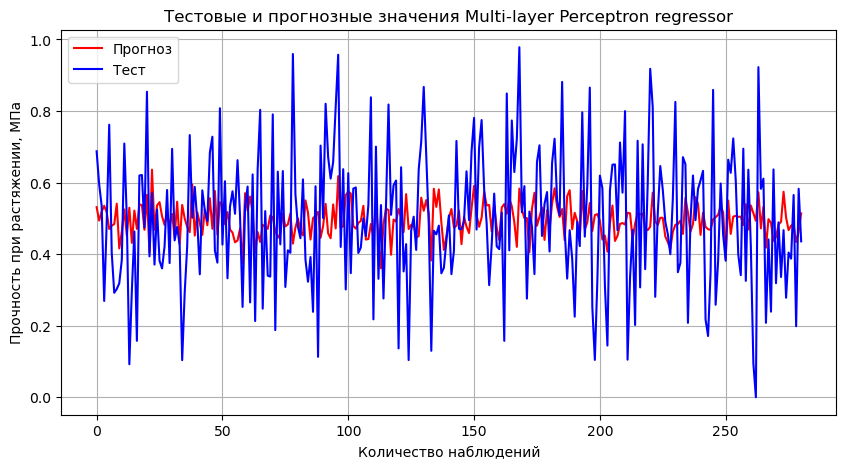

In [17]:
plt.figure(figsize = (10, 5))
plt.title('Тестовые и прогнозные значения Multi-layer Perceptron regressor')
plt.plot(Y_pred_mlp2, label = 'Прогноз', color = 'red')
plt.plot(Y_test2.values, label = 'Тест', color = 'blue')
plt.xlabel('Количество наблюдений')
plt.ylabel('Прочность при растяжении, МПа')
plt.legend()
plt.grid(True);

### выбор оптимальных параметров

#### По заданию произведём поиск гиперпараметровпо сетке с перекрстной проверкой и количеством блоков = 10
#### В методе  по описанию  для GridSearchCV выберем следующие параметры: 

In [19]:
MLPReg_optim2 = MLPRegressor()
MLPReg_optim2_params = {'hidden_layer_sizes' : [10, 20,], 'activation' : ['relu', 'tanh'],
                        'tol' : [0.0001, 0.0002], 'batch_size' : [200, 300,], 
                        'learning_rate' : ['constant', ], 'max_iter' : [200]}

#### Обучаем модель. Для оценки результата используем коэффициент детерминации R^2.

In [20]:
MLPReg_optim2 = GridSearchCV(MLPReg_optim2, MLPReg_optim2_params, cv = 10, verbose = 1, n_jobs= 20, scoring = 'r2')
MLPReg_optim2.fit(X_train2, Y_train2)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


/home/alexander/miniconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alexander/miniconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alexander/miniconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=10, estimator=MLPRegressor(), n_jobs=20,
             param_grid={'activation': ['relu', 'tanh'],
                         'batch_size': [200, 300],
                         'hidden_layer_sizes': [10, 20],
                         'learning_rate': ['constant'], 'max_iter': [200],
                         'tol': [0.0001, 0.0002]},
             scoring='r2', verbose=1)


#### Выводим гиперпараметры для оптимальной модели

In [21]:
print('оптимальные гиперпараметры для модели MLPRegressor()')
print(MLPReg_optim2.best_estimator_)
print(MLPReg_optim2.best_params_)
grid_search_MLPReg = MLPReg_optim2.best_estimator_
score_MLPReg_params = grid_search_MLPReg.score(X_test2, Y_test2).round(3)
print('R2 score параметры модели', score_MLPReg_params)

оптимальные гиперпараметры для модели MLPRegressor()
MLPRegressor(batch_size=200, hidden_layer_sizes=20)
{'activation': 'relu', 'batch_size': 200, 'hidden_layer_sizes': 20, 'learning_rate': 'constant', 'max_iter': 200, 'tol': 0.0001}
R2 score параметры модели -0.222


#### Подставим найденные параметры и посмотрим на изменения

In [22]:
mlp3 = MLPRegressor(random_state = 1, activation = 'relu', batch_size = 200, hidden_layer_sizes = 20, 
                    learning_rate = 'constant', max_iter = 200, tol = 0.0001)
mlp3.fit(X_train2, Y_train2)
Y_pred_mlp3 = mlp3.predict(X_test2)
mae_mpl_train3 = mean_absolute_error(Y_test2, Y_pred_mlp3)
mse_mlp_test3 = mean_squared_error(Y_test2, Y_pred_mlp3)
train_score_MLPReg3 = mlp3.score(X_train2, Y_train2).round(3)
test_score_MLPReg3 = mlp3.score(X_test2, Y_test2).round(3)


In [23]:
print('Multi-layer Perceptron regressor Results Train after optimization:')
print('Test score:          ', mlp3.score(X_test2, Y_test2).round(3))
print('Train score:         ', mlp3.score(X_train2, Y_train2).round(3))
print('MLPRegressor_MAE:    ', mean_absolute_error(Y_test2, Y_pred_mlp3).round(3))
print('MLPRegressor_MAPE:   ', mean_absolute_percentage_error(Y_test2, Y_pred_mlp3).round(3))
print('MLPRegressor_MSE:    ', mae_mlp_train2.round(3))
print('MLPRegressor_RMSE:   ', np.sqrt(mse_mlp_test3).round(3))

Multi-layer Perceptron regressor Results Train after optimization:
Test score:           -0.106
Train score:          -0.069
MLPRegressor_MAE:     0.158
MLPRegressor_MAPE:    7374214130925.274
MLPRegressor_MSE:     0.149
MLPRegressor_RMSE:    0.197


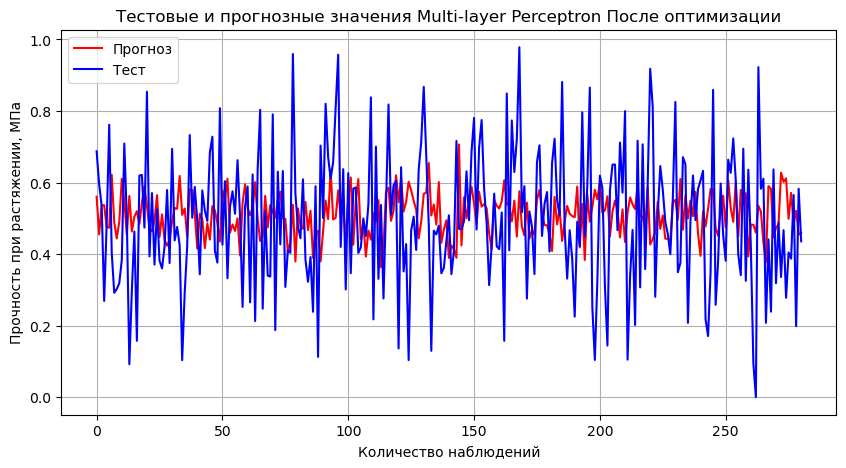

In [24]:
plt.figure(figsize = (10, 5))
plt.title('Тестовые и прогнозные значения Multi-layer Perceptron После оптимизации')
plt.plot(Y_pred_mlp3, label = "Прогноз", color = 'red')
plt.plot(Y_test2.values, label = "Тест", color = 'blue')
plt.xlabel('Количество наблюдений')
plt.ylabel('Прочность при растяжении, МПа')
plt.legend()
plt.grid(True);


# Сравним результаты

In [26]:
print('Регрессия : Multi-layer Perceptron regressor')
error_data_mpl = { 'MAE до оптимизации': [mae_mlp_train2], 'MAE после оптимизации': [mae_mpl_train3],
                  'MSE до оптимизации': [mse_mlp_test2],'MSE после оптимизации': [mse_mlp_test3], 
                  'R2 Test score до оптимизации' : [test_score_MLPReg2], 'R2 Test score после оптимизации' : [test_score_MLPReg3], 
                  'R2 Train score до оптимизации' : [train_score_MLPReg2], 'R2 Train score после оптимизации' : [train_score_MLPReg3]} 
error_data_mpl = pd.DataFrame(error_data_mpl)
print(error_data_mpl.T)

Регрессия : Multi-layer Perceptron regressor
                                         0
MAE до оптимизации                0.148695
MAE после оптимизации             0.158423
MSE до оптимизации                0.033972
MSE после оптимизации             0.038746
R2 Test score до оптимизации      0.030000
R2 Test score после оптимизации  -0.106000
R2 Train score до оптимизации     0.006000
R2 Train score после оптимизации -0.069000


In [69]:
print('Регрессия : Multi-layer Perceptron regressor')
error_data_mpl = { 'MAE до оптимизации': [mae_mlp_train2], 'MAE после оптимизации': [mae_mlp_train3],
                  'MSE до оптимизации': [mse_mlp_test2],'MSE после оптимизации': [mse_mlp_test3], 
                  'R2 Test score до оптимизации' : [test_score_MLPReg2], 'R2 Test score после оптимизации' : [test_score_MLPReg3], 
                  'R2 Train score до оптимизации' : [train_score_MLPReg2], 'R2 Train score после оптимизации' : [train_score_MLPReg3]} 
error_data_mpl = pd.DataFrame(error_data_mpl)
print(error_data_mpl.T)

Регрессия : Multi-layer Perceptron regressor
                                         0
MAE до оптимизации                0.148695
MAE после оптимизации             0.156674
MSE до оптимизации                0.033972
MSE после оптимизации             0.038353
R2 Test score до оптимизации      0.030000
R2 Test score после оптимизации  -0.095000
R2 Train score до оптимизации     0.006000
R2 Train score после оптимизации -0.073000
